In [108]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1, rho, Nsquared


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [109]:
# %cd /work/eay/CM2.6
# ds = xr.Dataset({'u_full': u_full})
# print('done')
# ds.to_netcdf('u_1year_CM2_1deg.nc', 'w')
# %cd /work/eay/CM2.6
# ds = xr.Dataset({'v_full': v_full})
# print('done')
# ds.to_netcdf('v_1year_CM2_1deg.nc', 'w')

### For CM2.6 data:

In [110]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs = xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t'][::10,::10]; lat=fs['geolat_t'][::10,::10]
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_c']/360 *2*np.pi);

%cd /work/eay/
u_full = xr.open_dataset('u_1year_CM2.6.nc')['u_full']
v_full = xr.open_dataset('v_1year_CM2.6.nc')['v_full']
zl = xr.open_dataset('v_1year_CM2.6.nc')['st_ocean']
print('done')

%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history
salt = (xr.open_dataset('02020101.ocean_minibling_field_salt.nc')['salt'][::10,:,::10,::10])
temp = (xr.open_dataset('02020101.ocean_minibling_field_temp.nc')['temp'][::10,:,::10,::10])
z_edges  = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u_full.st_ocean})



/net2/smg/documents/OMDT/analysis_CM2p6/grids
/work2/eay
done
/arch2/rds/CM2.6/CM2.6_A_Control-1860_V03/history


In [111]:
%%time
salt =salt.mean('time')
print('done with salt')
temp =temp.mean('time')


done with salt
CPU times: user 11.5 s, sys: 11.8 s, total: 23.3 s
Wall time: 3min 35s


In [113]:
#zl*9.8*1025/1e4
#print(salt)
#print(temp)
print(lon.shape,lat.shape)

(270, 360) (270, 360)


In [114]:
pressure=p_from_z(-zl,lat) #In dbar, 1e4 Pa; sea pressure i.e. absolute pressure - 10.1325 dbar 
#print(pressure[:,50,50])
SA = SA_from_SP(salt, pressure, lon, lat)
CT = CT_from_pt(SA,temp)
N2,N2depth = np.array(Nsquared(SA, CT, pressure, axis=0))
#print(SA[:,50,50],print(salt[:,50,50]))
#print(CT[:,50,50],temp[:,50,50])

In [115]:
N2depth[:,50,50]

array([  10.16280435,   20.35209587,   30.57823796,   40.85496735,
         51.20177719,   61.64533966,   72.22283052,   82.98547172,
         94.00378619,  105.3755814 ,  117.23494673,  129.76621613,
        143.22134328,  157.94279474,  174.39326984,  193.19094968,
        215.1510758 ,  241.32817765,  273.05208487,  311.94177941,
        359.87645858,  418.90054696,  491.04441755,  578.07328242,
        681.20755989,  800.90043497,  936.74990626, 1087.58251653,
       1251.67254724, 1427.02008289, 1611.60252183, 1803.55471284,
       2001.26618165, 2203.41134932, 2408.93739489, 2617.02841284,
       2827.06560068, 3038.58431369, 3251.2404281 , 3464.77944069,
       3679.01639147, 3893.81482192, 4109.07525921, 4324.72666951,
       4540.71557552, 4757.00395262, 4973.56456063, 5190.3761535 ,
       5407.4239379 ])

In [143]:
np.max(N2depth[:,50,60]-N2depth[:,50,50])

0.0

In [147]:
N2 = xr.DataArray(N2,dims   = ['depth','yu_ocean','xu_ocean'],
                       coords={'depth': N2depth[:,50,50],
                               'yu_ocean':u_full.yu_ocean,
                               'xu_ocean':u_full.xu_ocean})

In [148]:
%cd /work/eay/CM2.6
ds = xr.Dataset({'N2': N2})
print('done')
ds.to_netcdf('CM2.6_N2_gsw.nc', 'w')
print('done')

/work2/eay/CM2.6
done
done


In [149]:
%cd /work/eay/CM2.6
test = xr.open_dataset('CM2.6_N2_gsw.nc')
print(test)


/work2/eay/CM2.6
<xarray.Dataset>
Dimensions:   (depth: 49, yu_ocean: 270, xu_ocean: 360)
Coordinates:
  * depth     (depth) float64 10.16 20.35 30.58 ... 4.974e+03 5.19e+03 5.407e+03
  * yu_ocean  (yu_ocean) float64 -81.09 -80.67 -80.24 ... 88.78 89.2 89.62
  * xu_ocean  (xu_ocean) float64 -279.9 -278.9 -277.9 -276.9 ... 77.1 78.1 79.1
Data variables:
    N2        (depth, yu_ocean, xu_ocean) float64 ...


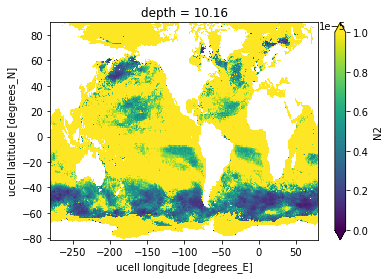

In [150]:
test.N2[0,:,:].plot(vmin=0,vmax=1e-5)

## Computing N2 alternatively:

In [101]:
%%time
density_np = rho(salt,temp,0)
print('done')


done
CPU times: user 165 ms, sys: 10.9 ms, total: 175 ms
Wall time: 173 ms


In [102]:
density = xr.DataArray(density_np,dims   = ['st_ocean','yu_ocean','xu_ocean'],
                       coords={'yu_ocean':u_full.yu_ocean,
                               'xu_ocean':u_full.xu_ocean,
                               'st_ocean':u_full.st_ocean})



drhodz = density.differentiate('st_ocean')
N2_alt = (9.8*drhodz/1025)

In [104]:
print(N2[:,50,50])
print(N2_alt[:,50,50])

[2.48415119e-06 7.16080074e-06 3.99894162e-05 4.41690168e-05
 2.45749138e-05 8.46819640e-06 1.62125545e-05 8.86454036e-06
 2.93416752e-06 3.17980646e-06 6.63966477e-06 1.63361942e-05
 2.76859686e-05 3.17947955e-05 2.13004442e-05 8.60856746e-06
 7.65134522e-06 6.88598343e-06 6.04700535e-06 5.31616235e-06
 4.82341382e-06 4.55711199e-06 4.13386773e-06 3.80873542e-06
 3.46098441e-06 2.98588869e-06 2.36800112e-06 1.73716241e-06
 1.36841173e-06 1.32782890e-06 1.30562248e-06 1.14509088e-06
 9.13602783e-07 6.70955491e-07 4.67009995e-07 3.51281996e-07
 3.00572454e-07 2.65001801e-07 2.37594628e-07 2.17786170e-07
 2.08897426e-07 1.85288880e-07 2.00731227e-07 1.08147200e-07
 1.18310600e-08            nan            nan            nan
            nan]
<xarray.DataArray 'salt' (st_ocean: 50)>
array([2.40634651e-06, 4.80461442e-06, 2.34451007e-05, 4.16095798e-05,
       3.38105054e-05, 1.61473861e-05, 1.19106888e-05, 1.21229478e-05,
       5.59550601e-06, 2.81073415e-06, 4.67551729e-06, 1.12509122e-0

In [18]:
u_full

<xarray.DataArray 'u_full' (time: 73, st_ocean: 50, yu_ocean: 270, xu_ocean: 360)>
[354780000 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -278.9 -277.9 -276.9 ... 77.1 78.1 79.1
  * yu_ocean  (yu_ocean) float64 -81.09 -80.67 -80.24 ... 88.78 89.2 89.62
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 0201-01-03 12:00:00 ... 0201-12-29 12:00:00
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_x_velocity

In [170]:
# ds = xr.Dataset({
#     'EOF1u': xr.DataArray(
#                 data   = saved_eof1u,   # enter data here
#                 dims   = ['zl','lat','lon'],
#                 coords = {'zl': zl, 'lat': lat_coarse.values, 'lon': lon_coarse.values}),
#     'EOF1v': xr.DataArray(
#                 data   = saved_eof1v,   # enter data here
#                 dims   = ['zl','lat','lon'],
#                 coords = {'zl': zl, 'lat': lat_coarse.values, 'lon': lon_coarse.values}
#                 ),
#     'pvaru': xr.DataArray(
#                 data   = saved_pvaru,   # enter data here
#                 dims   = ['lat','lon'],
#                 coords = {'lat': lat_coarse.values, 'lon': lon_coarse.values}
#                 ),
#     'pvarv': xr.DataArray(
#                 data   = saved_pvarv,   # enter data here
#                 dims   = ['lat','lon'],
#                 coords = {'lat': lat_coarse.values, 'lon': lon_coarse.values}
#                 )
#             })
# print('done')
# %cd /work/eay/
# ds.to_netcdf('EOF_analysis_CM2.6.nc', 'w')

done
/work2/eay


In [21]:
%cd /work/eay/CM2.6
test = xr.open_dataset('CM2.6_N2.nc')
print(test)


/work2/eay/CM2.6
<xarray.Dataset>
Dimensions:   (yu_ocean: 270, xu_ocean: 360, st_ocean: 50)
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.09 -80.67 -80.24 ... 88.78 89.2 89.62
  * xu_ocean  (xu_ocean) float64 -279.9 -278.9 -277.9 -276.9 ... 77.1 78.1 79.1
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
Data variables:
    N2        (st_ocean, yu_ocean, xu_ocean) float64 ...


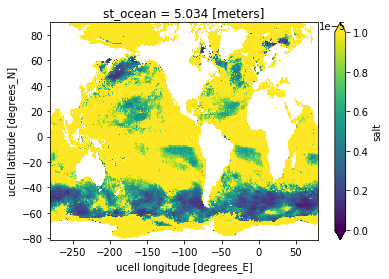

In [28]:
N2[0,:].plot(vmin=0,vmax=1e-5)

In [29]:
test

<xarray.Dataset>
Dimensions:   (yu_ocean: 270, xu_ocean: 360, st_ocean: 50)
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.09 -80.67 -80.24 ... 88.78 89.2 89.62
  * xu_ocean  (xu_ocean) float64 -279.9 -278.9 -277.9 -276.9 ... 77.1 78.1 79.1
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
Data variables:
    N2        (st_ocean, yu_ocean, xu_ocean) float64 ...